# FX Quant Insight — Chart Preview

Preview all chart visualizations before deploying to the Telegram bot.  
Loads cached data from parquet files (or generates synthetic data if cache is empty).  
Each section shows the **methodology** followed by the **Bloomberg-styled chart**.

In [1]:
import sys, os
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path(os.getcwd()).parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
from IPython.display import display, Image, Markdown

print(f"Project root: {PROJECT_ROOT}")

Project root: s:\Github\Trading\tele_bot


In [ ]:
# Import charts and methodology
from src.report.charts import (
    chart_technical_matrix,
    chart_event_table,
    chart_cars,
    chart_timezone_summary,
    chart_timezone_heatmap,
    chart_pca_etf,
    chart_pca_fx,
)
from src.bot.methodology import METHODOLOGIES


def methodology_md(key: str) -> str:
    """Convert methodology entry to displayable markdown."""
    entry = METHODOLOGIES[key]
    title = entry["title"]
    desc = entry["description"]
    metrics = entry["metrics"].replace("<b>", "**").replace("</b>", "**")
    signals = entry["signals"].replace("<b>", "**").replace("</b>", "**")
    return (
        f"### {title}\n\n"
        f"{desc}\n\n"
        f"#### Metrics\n{metrics}\n\n"
        f"#### Signals\n{signals}"
    )


USE_REAL_DATA = False

try:
    from src.data.cache import DataCache
    from src.data.tickers import ALL_FX_PAIRS, G10_PAIRS, CROSS_ASSET, ALL_PCA_ETFS
    import yaml
    
    settings_path = PROJECT_ROOT / "config" / "settings.yaml"
    with open(settings_path) as f:
        settings = yaml.safe_load(f)
    cache_dir = PROJECT_ROOT / settings["data"]["cache_dir"]
    cache = DataCache(cache_dir)
    
    test_df = cache.get_daily("EURUSD")
    if test_df is not None and not test_df.empty:
        USE_REAL_DATA = True
        print(f"Using REAL cached data ({len(test_df)} EURUSD bars)")
    else:
        print("Cache empty — will use synthetic data")
except Exception as e:
    print(f"Cannot load cache ({e}) — will use synthetic data")

Using REAL cached data (430 EURUSD bars)


## Synthetic Data Generator
Creates realistic-looking DataFrames matching the analysis output schemas.

In [37]:
np.random.seed(42)

PAIRS = ["EURUSD", "USDJPY", "GBPUSD", "AUDUSD", "NZDUSD",
         "USDCAD", "USDCHF", "USDNOK", "USDSEK",
         "USDCNH", "USDINR", "USDKRW", "USDSGD", "USDTHB", "USDMYR"]

G10 = ["EURUSD", "USDJPY", "GBPUSD", "AUDUSD", "NZDUSD",
       "USDCAD", "USDCHF", "USDNOK", "USDSEK"]

SIGNALS = ["Bullish", "Sl. Bullish", "Bearish", "Sl. Bearish", "No Signal"]
EVENT_SIGNALS = ["Bullish Cont.", "Bullish Contr.", "Bearish Cont.", "Bearish Contr.", "No Signal"]
TRENDS = ["\u2191", "\u2193", "\u2194"]
ADX_TRENDS = ["Uptrend", "Downtrend", "Range", "Transition"]
BOLLINGER = ["Upper", "Lower", "None"]


def make_technical_matrix():
    rows = []
    for p in PAIRS:
        spot = np.random.uniform(0.6, 160)
        rows.append({
            "Pair": p, "Spot": spot,
            "Trend": np.random.choice(TRENDS),
            "Signal": np.random.choice(SIGNALS),
            "ADX Trend": np.random.choice(ADX_TRENDS),
            "Bollinger": np.random.choice(BOLLINGER),
            "Next Support": spot * 0.98,
            "Next Resistance": spot * 1.02,
        })
    return pd.DataFrame(rows).set_index("Pair")


def make_event_table():
    rows = []
    for p in PAIRS:
        spot = np.random.uniform(0.6, 160)
        rows.append({
            "Pair": p,
            "Old Spot": spot * 0.99,
            "New Spot": spot,
            "1m Vol": np.random.uniform(5, 20),
            "1m Vol Chg": np.random.uniform(-2, 2),
            "1w Vol": np.random.uniform(4, 18),
            "1w Vol Chg": np.random.uniform(-3, 3),
            "Ret vs USD": np.random.uniform(-3, 3),
            "Signal": np.random.choice(EVENT_SIGNALS),
        })
    return pd.DataFrame(rows).set_index("Pair")


def make_cars():
    rows = []
    for p in G10:
        ccy = p.replace("USD", "")
        rows.append({
            "Currency": ccy,
            "Bullish/Bearish": np.random.choice(["Bullish", "Bearish"]),
            "Equity": np.random.randint(1, 11),
            "Rates": np.random.randint(1, 11),
            "Commodity": np.random.randint(1, 11),
        })
    df = pd.DataFrame(rows).set_index("Currency")
    df.attrs["regime"] = np.random.choice(["Shock", "Normal"])
    df.attrs["performing_factor"] = "equity"
    df.attrs["equity_z"] = np.random.uniform(-2, 2)
    df.attrs["bond_z"] = np.random.uniform(-2, 2)
    df.attrs["commodity_z"] = np.random.uniform(-2, 2)
    return df


def make_timezone_summary():
    rows = [{"Pair": p,
             "America": np.random.uniform(-1.5, 1.5),
             "Europe": np.random.uniform(-1.5, 1.5),
             "Asia": np.random.uniform(-1.5, 1.5)}
            for p in PAIRS]
    return pd.DataFrame(rows).set_index("Pair")


def make_timezone_heatmap():
    slots = ["8am-11am", "11am-2pm", "2pm-5pm", "5pm-8pm",
             "8pm-11pm", "11pm-2am", "2am-5am", "5am-8am"]
    rows = []
    for p in PAIRS:
        row = {"Pair": p}
        for s in slots:
            row[s] = np.random.uniform(-0.8, 0.8)
        rows.append(row)
    return pd.DataFrame(rows).set_index("Pair")


def make_pca_etf():
    etfs = ["SPY", "QQQ", "IWM", "XLF", "XLE", "XLK", "XLV", "XLI",
            "EFA", "EEM", "TLT", "IEF", "HYG", "LQD", "GLD", "SLV",
            "DBC", "USO", "FXI", "EWJ", "EWG", "EWU"]
    n = 5
    loadings = pd.DataFrame(
        np.random.uniform(-0.5, 0.5, (len(etfs), n)),
        index=etfs, columns=[f"PC{i+1}" for i in range(n)]
    )
    var_exp = np.array([0.35, 0.15, 0.10, 0.07, 0.05])
    return {
        "loadings": loadings,
        "eigenvalues": (var_exp * 10).tolist(),
        "variance_explained": var_exp.tolist(),
        "cumulative_variance": np.cumsum(var_exp).tolist(),
        "effective_dim": 4.2,
        "regime": "Diversified",
        "n_assets": len(etfs),
        "window": 120,
        "top_loadings_per_pc": {},
    }


def make_pca_fx():
    pairs = G10
    n = 3
    loadings = pd.DataFrame(
        np.random.uniform(-0.6, 0.6, (len(pairs), n)),
        index=[p.replace("USD", "") for p in pairs],
        columns=[f"PC{i+1}" for i in range(n)]
    )
    var_exp = np.array([0.45, 0.20, 0.12])
    scores = pd.Series([1.5, -0.8, 0.3], index=["PC1", "PC2", "PC3"])
    zscores = pd.Series([2.3, -1.1, 0.5], index=["PC1", "PC2", "PC3"])
    return {
        "loadings": loadings,
        "eigenvalues": (var_exp * 10).tolist(),
        "variance_explained": var_exp.tolist(),
        "cumulative_variance": np.cumsum(var_exp).tolist(),
        "effective_dim": 2.8,
        "regime": "Concentrated",
        "labels": {"PC1": "Dollar Factor", "PC2": "Carry Factor", "PC3": "Regional / Momentum"},
        "pc_scores": scores,
        "pc_zscores": zscores,
        "n_assets": len(pairs),
        "window": 120,
    }

print("Synthetic data generators ready.")

Synthetic data generators ready.


## Generate Data
Use real cached data if available, otherwise synthetic.

In [38]:
DATA_DATE = "2026-02-16"  # placeholder for subtitle display

if USE_REAL_DATA:
    from src.analysis.technical_matrix import build_technical_matrix
    from src.analysis.event_analysis import build_event_table
    from src.analysis.cars import build_cars_report
    from src.analysis.timezone import build_timezone_summary, build_timezone_heatmap
    from src.analysis.pca_etf import build_pca_etf_report
    from src.analysis.pca_fx import build_pca_fx_report
    
    all_daily = {p: cache.get_daily(p) for p in ALL_FX_PAIRS
                 if cache.get_daily(p) is not None}
    g10_daily = {p: df for p, df in all_daily.items() if p in G10_PAIRS}
    all_hourly = {p: cache.get_hourly(p) for p in ALL_FX_PAIRS
                  if cache.get_hourly(p) is not None}
    
    # Get actual data date
    _eurusd = cache.get_daily("EURUSD")
    if _eurusd is not None and len(_eurusd) > 0:
        DATA_DATE = str(_eurusd.index[-1].date())
    
    tech_df = build_technical_matrix(all_daily)
    event_df = build_event_table(all_daily, cache.get_cross_asset(CROSS_ASSET["vix"]))
    cars_df = build_cars_report(
        g10_daily,
        cache.get_cross_asset(CROSS_ASSET["equity"]),
        cache.get_cross_asset(CROSS_ASSET["bonds"]),
        cache.get_cross_asset(CROSS_ASSET["commodities"]),
    )
    tz_summary = build_timezone_summary(all_hourly, 5)
    tz_heatmap = build_timezone_heatmap(all_hourly, 5)
    
    etf_data = {s: cache.get_cross_asset(s) for s in ALL_PCA_ETFS
                if cache.get_cross_asset(s) is not None}
    pca_etf_report = build_pca_etf_report(etf_data)
    pca_fx_report = build_pca_fx_report(g10_daily)
    
    print(f"Real data loaded: {len(all_daily)} pairs, {len(etf_data)} ETFs, date: {DATA_DATE}")
else:
    tech_df = make_technical_matrix()
    event_df = make_event_table()
    cars_df = make_cars()
    tz_summary = make_timezone_summary()
    tz_heatmap = make_timezone_heatmap()
    pca_etf_report = make_pca_etf()
    pca_fx_report = make_pca_fx()
    
    print(f"Using synthetic data (date: {DATA_DATE})")

Using synthetic data (date: 2026-02-16)


---
## 1. Technical Matrix

In [39]:
display(Markdown(methodology_md("technicals")))

### Technical Matrix

Combines four positioning/momentum indicators to produce a directional signal for each FX pair. Inspired by BAML's FX Positioning & Technicals framework.

#### Metrics
**MAA (Moving Average Aggregator)**
Average of 28 short/long SMA crossover signals (e.g. 5/20, 10/50, 20/200). Score 0-100.
• >60 = Uptrend positioning
• <40 = Downtrend positioning
• 40-60 = Neutral

**UD (Up/Down Volatility)**
Ratio of downside to total realized vol, expressed as a 1-year percentile rank. High UD = greater downside moves = bearish.

**RS (Residual Skew)**
Rolling 26-week skewness of weekly returns, 1-year percentile rank. High RS = stretched long positioning.

**ADX Trend**
• <20: Range
• 20-25: Transition
• >25: Trending (direction from DMI+/DMI-)

**Bollinger Bands**
20-day, 2σ bands. Upper/Lower flags when spot breaches.

#### Signals
**Uptrend (MAA>60):**
• Bullish: UD<50 AND RS<50 (clean continuation)
• Bearish: UD>80 AND RS>80 (reversal risk)
• Sl. Bullish/Bearish: one indicator supports

**Downtrend (MAA<40):**
• Bullish: UD<20 AND RS<20 (reversal candidate)
• Bearish: UD>50 AND RS>50 (continuation)
• Sl. Bullish/Bearish: one indicator supports

**Neutral (MAA 40-60):** No Signal

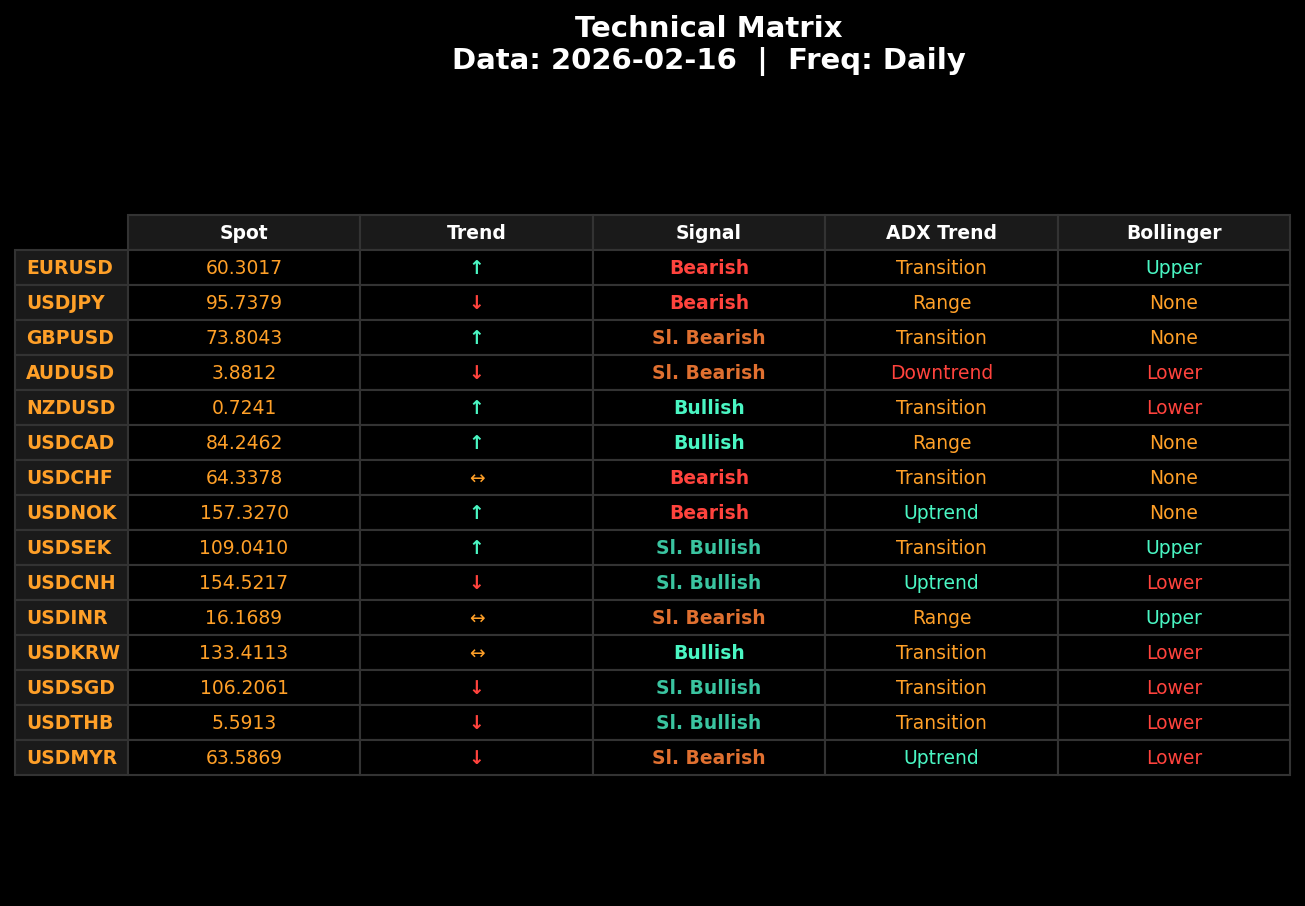

In [40]:
buf = chart_technical_matrix(tech_df, data_date=DATA_DATE, frequency="Daily")
display(Image(data=buf.getvalue()))

---
## 2. Event Analysis

In [41]:
display(Markdown(methodology_md("signals")))

### Event Analysis (Vol-Guided Signals)

Classifies each FX pair into directional signals based on the interaction between spot returns, realized volatility changes, and VIX moves over the past week.

#### Metrics
**Spot Return**
Week-over-week close change (5 trading days), sign-corrected so positive = foreign currency strength vs USD.

**Realized Vol (1w / 1m)**
Annualized rolling volatility over 5-day and 21-day windows. Change is measured vs 5 days ago.

**VIX Change**
Weekly change in VIX proxy (VIXY ETF). Rising VIX confirms risk-off moves.

#### Signals
**Bearish Continuation:**
Spot down >1% + Vol rising >0.5% + VIX rising → risk-off trend intact

**Bearish Contrarian:**
Spot up >1% + Vol rising sharply >1% → suspicious rally, high vol suggests stress

**Bullish Continuation:**
Spot up >1% + Vol falling → healthy risk-on, low-vol rally

**Bullish Contrarian:**
Spot down >1% + Vol falling + VIX falling → oversold bounce candidate

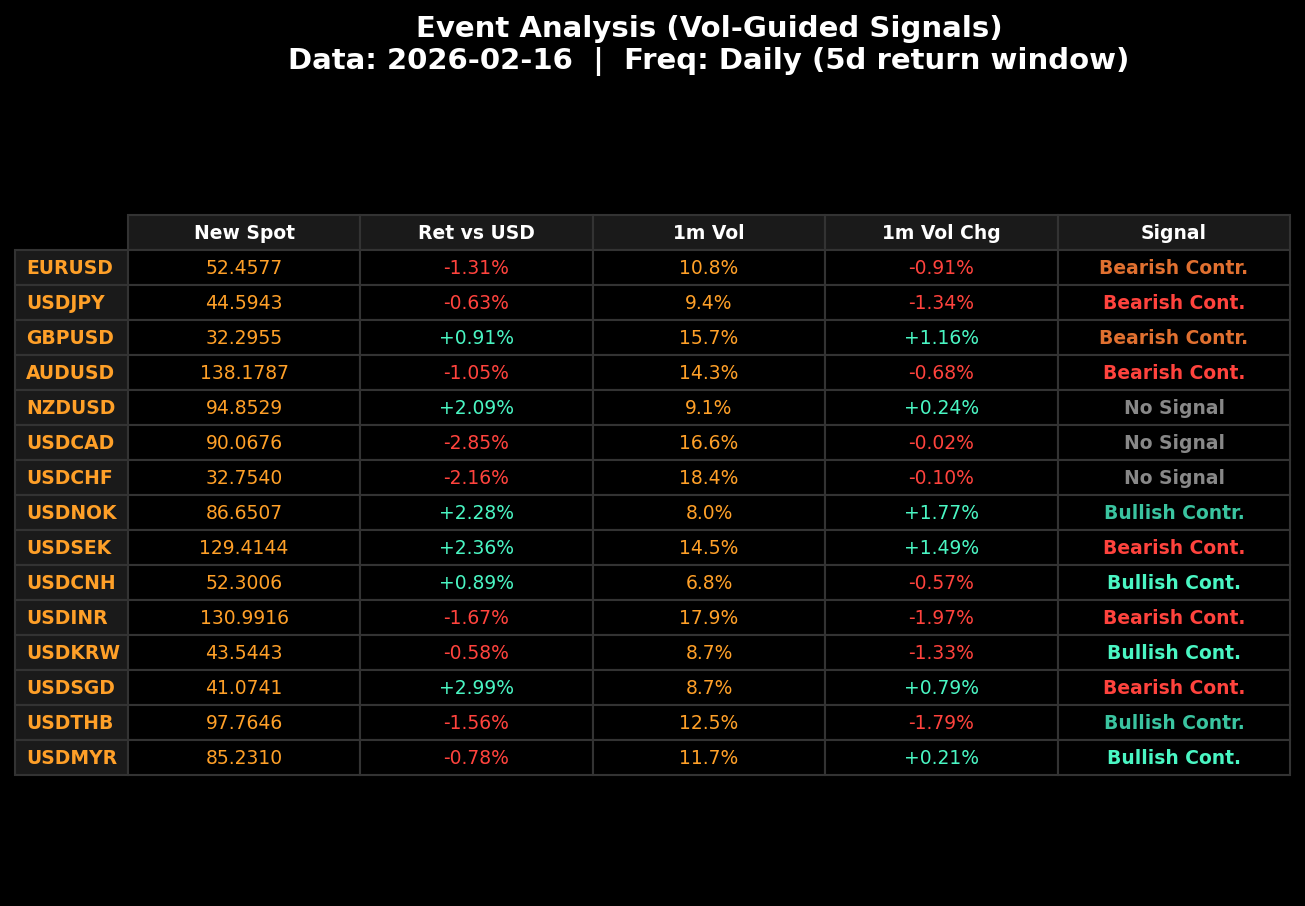

In [42]:
buf = chart_event_table(event_df, data_date=DATA_DATE, frequency="Daily (5d return window)")
display(Image(data=buf.getvalue()))

---
## 3. CARS — Cross-Asset Regime Switching

In [43]:
display(Markdown(methodology_md("cars")))

### CARS — Cross-Asset Regime Switching

Identifies whether markets are in a Shock or Normal regime using cross-asset z-scores, then ranks G10 currencies by their sensitivity to equity, rates, and commodity factors.

#### Metrics
**Regime Detection**
Weekly z-scores (52-week window) for:
• Equity (SPY): Shock if z < -1.0
• Bonds (TLT): Shock if z < -1.0 (yields spiking)
• Commodities (DBC): Shock if z < -2.0
Any breach → Shock regime.

**Factor Rankings**
52-week rolling correlation of each currency vs SPY, TLT, DBC. Currencies ranked 1-10 per factor.

#### Signals
**Shock Week:**
Buy JPY & CHF (safe havens), Sell all others vs USD.

**Normal Week:**
Rank by dominant performing factor:
• Top 3 → Bullish
• Bottom 3 → Bearish
• Middle → No Signal

**Commodity Overlay:**
If |commodity_z| > 2.0, override signal for currencies with top commodity sensitivity.

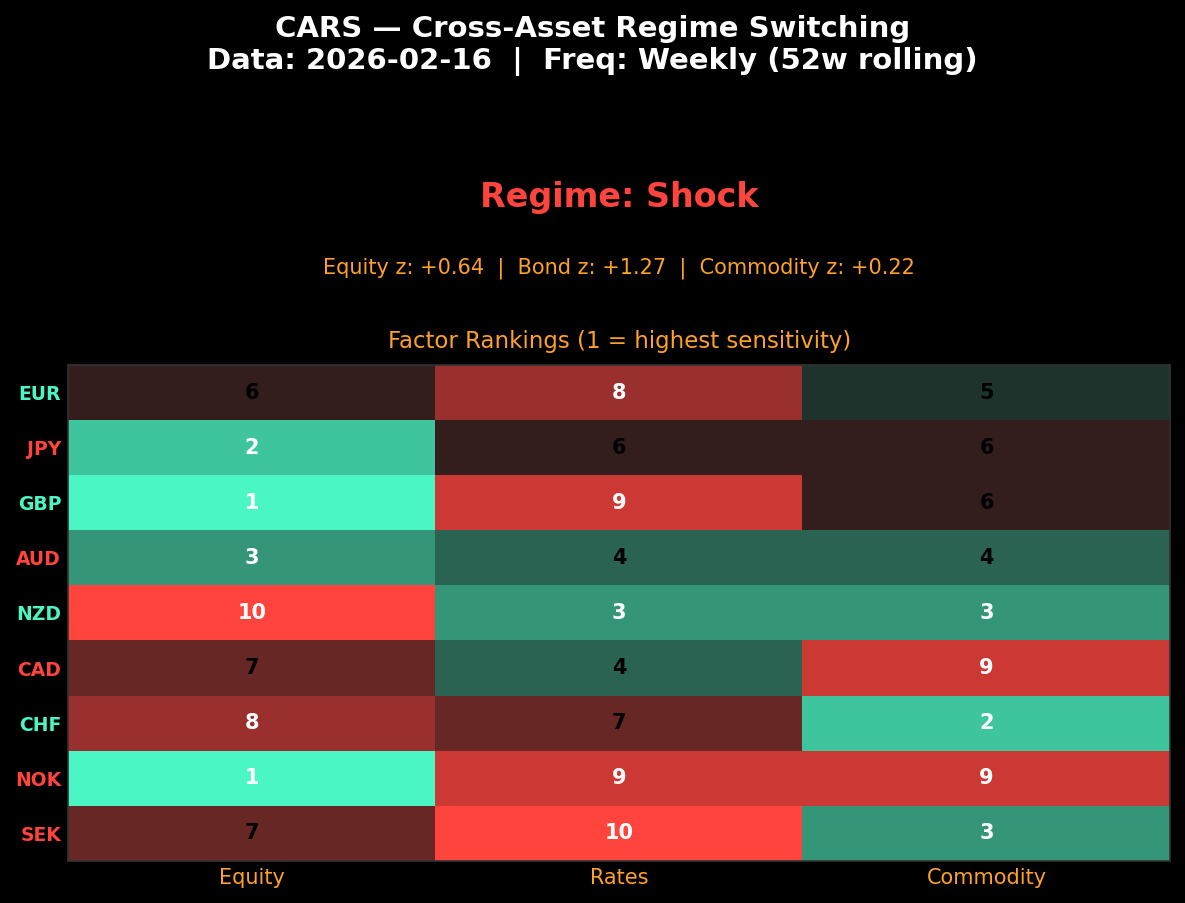

In [44]:
buf = chart_cars(cars_df, data_date=DATA_DATE, frequency="Weekly (52w rolling)")
if buf:
    display(Image(data=buf.getvalue()))
else:
    print("No CARS data")

---
## 4. Time Zone Returns

In [45]:
display(Markdown(methodology_md("timezone")))

### Time Zone Returns

Decomposes FX returns by trading session to reveal which time zone is driving price action. Uses hourly bar data.

#### Metrics
**Three Sessions (UTC):**
• Asia: 00:00-08:00
• Europe: 08:00-13:00
• Americas: 13:00-00:00

**Eight 3-Hour Slots:**
Granular breakdown from 8am-11am through 5am-8am UTC.

**Calculation:**
Cumulative hourly returns per zone over the lookback period (default 5 days). Expressed as percentage.

#### Signals
**How to read:**
• Large positive in Asia + flat elsewhere → Asian buying pressure
• Negative Americas + positive Europe → US selling, EU dip-buying
• Consistent one-zone dominance → flow-driven trend

**Lookback options:**
/timezone (5d) | /timezone 1m (21d) | /timezone 3m (63d)

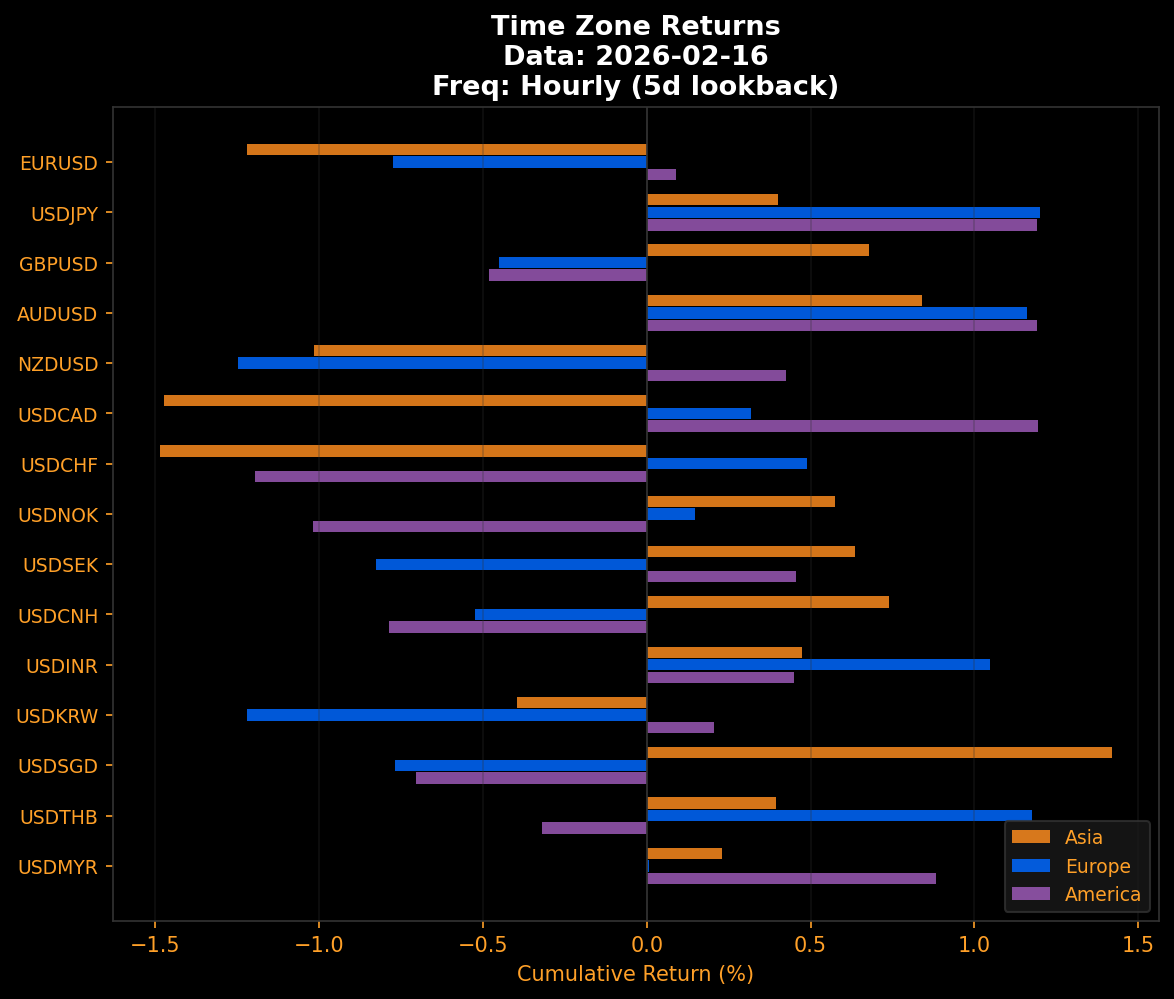

In [46]:
buf = chart_timezone_summary(tz_summary, data_date=DATA_DATE, frequency="Hourly (5d lookback)")
display(Image(data=buf.getvalue()))

### Time Zone Heatmap (3h slots)

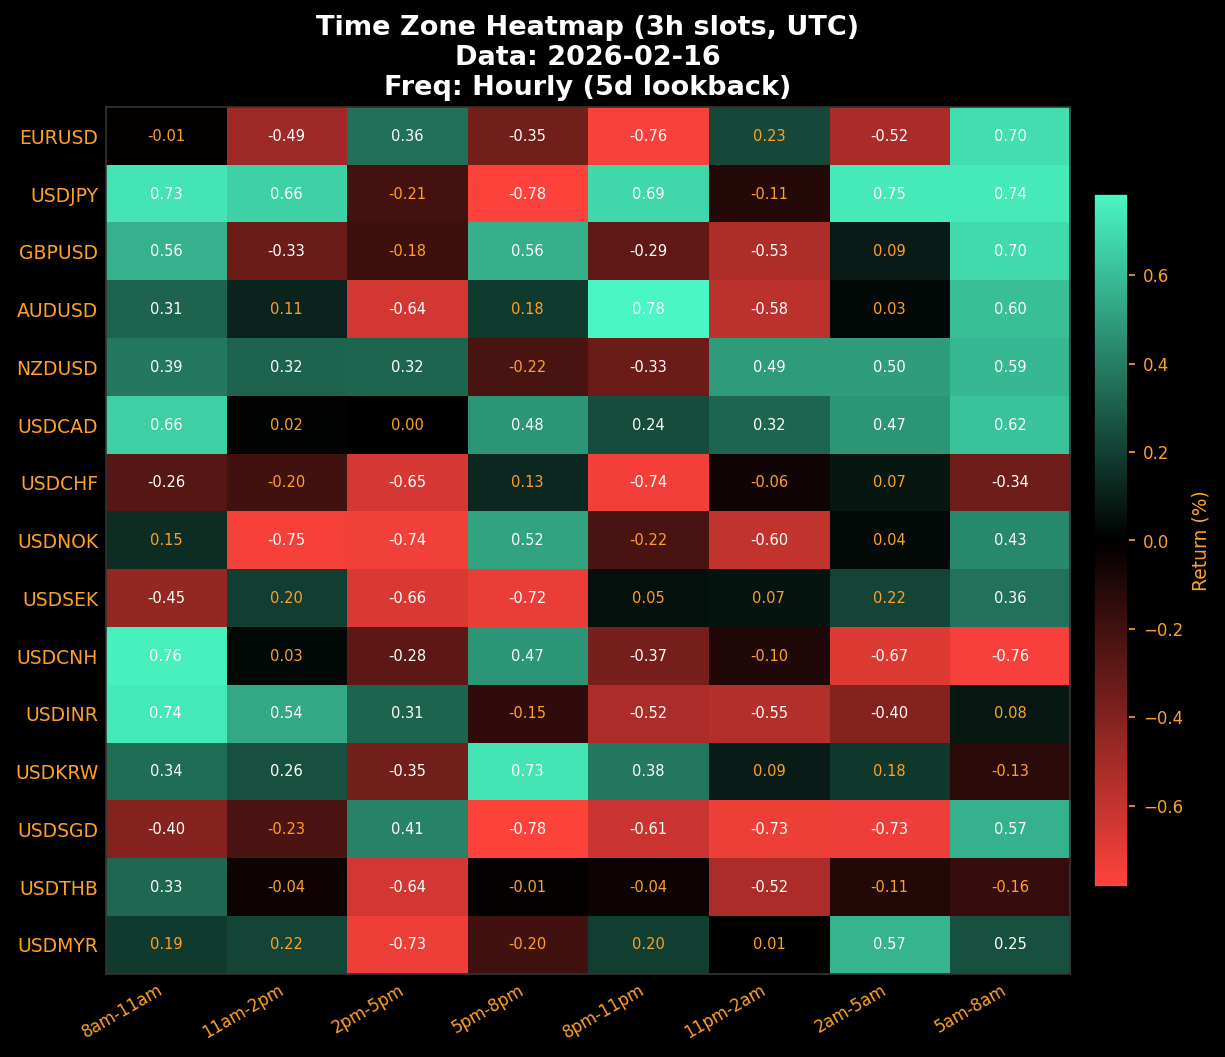

In [47]:
buf = chart_timezone_heatmap(tz_heatmap, data_date=DATA_DATE, frequency="Hourly (5d lookback)")
display(Image(data=buf.getvalue()))

---
## 5. PCA ETF (Scree + Loadings)

In [48]:
display(Markdown(methodology_md("pca_etf")))

### PCA — ETF Factor Decomposition

Runs PCA on 120-day log returns of ~25 ETFs across equities, sectors, international, fixed income, and commodities. Reveals the dominant risk factors and detects regime shifts.

#### Metrics
**Variance Explained:**
How much of total market movement each PC captures. PC1 typically 30-50% in normal markets.

**Effective Dimensionality:**
Participation ratio: (Σλ)²/Σλ². Measures how many independent factors drive the market.
• ≈1: One factor dominates (risk-off)
• ≈N: Fully diversified

**Loadings:**
Each ETF's weight on a PC. Large positive/negative = strongly driven by that factor.

#### Signals
**Dimensionality Collapse:**
PC1 > 60% variance OR eff. dim < 3.0 → single-factor risk-off. Correlations spike, diversification breaks down.

**Normal:**
Multiple independent factors. Read PC1 loadings for the dominant theme (e.g. risk-on/off), PC2-3 for sector rotation signals.

--- Chart 1 ---


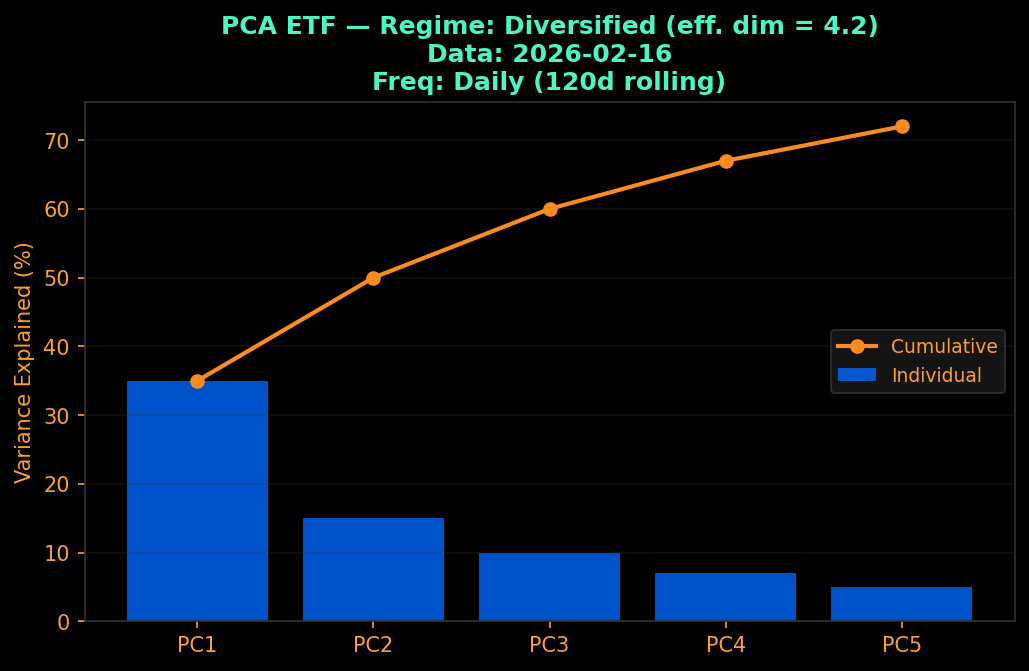

--- Chart 2 ---


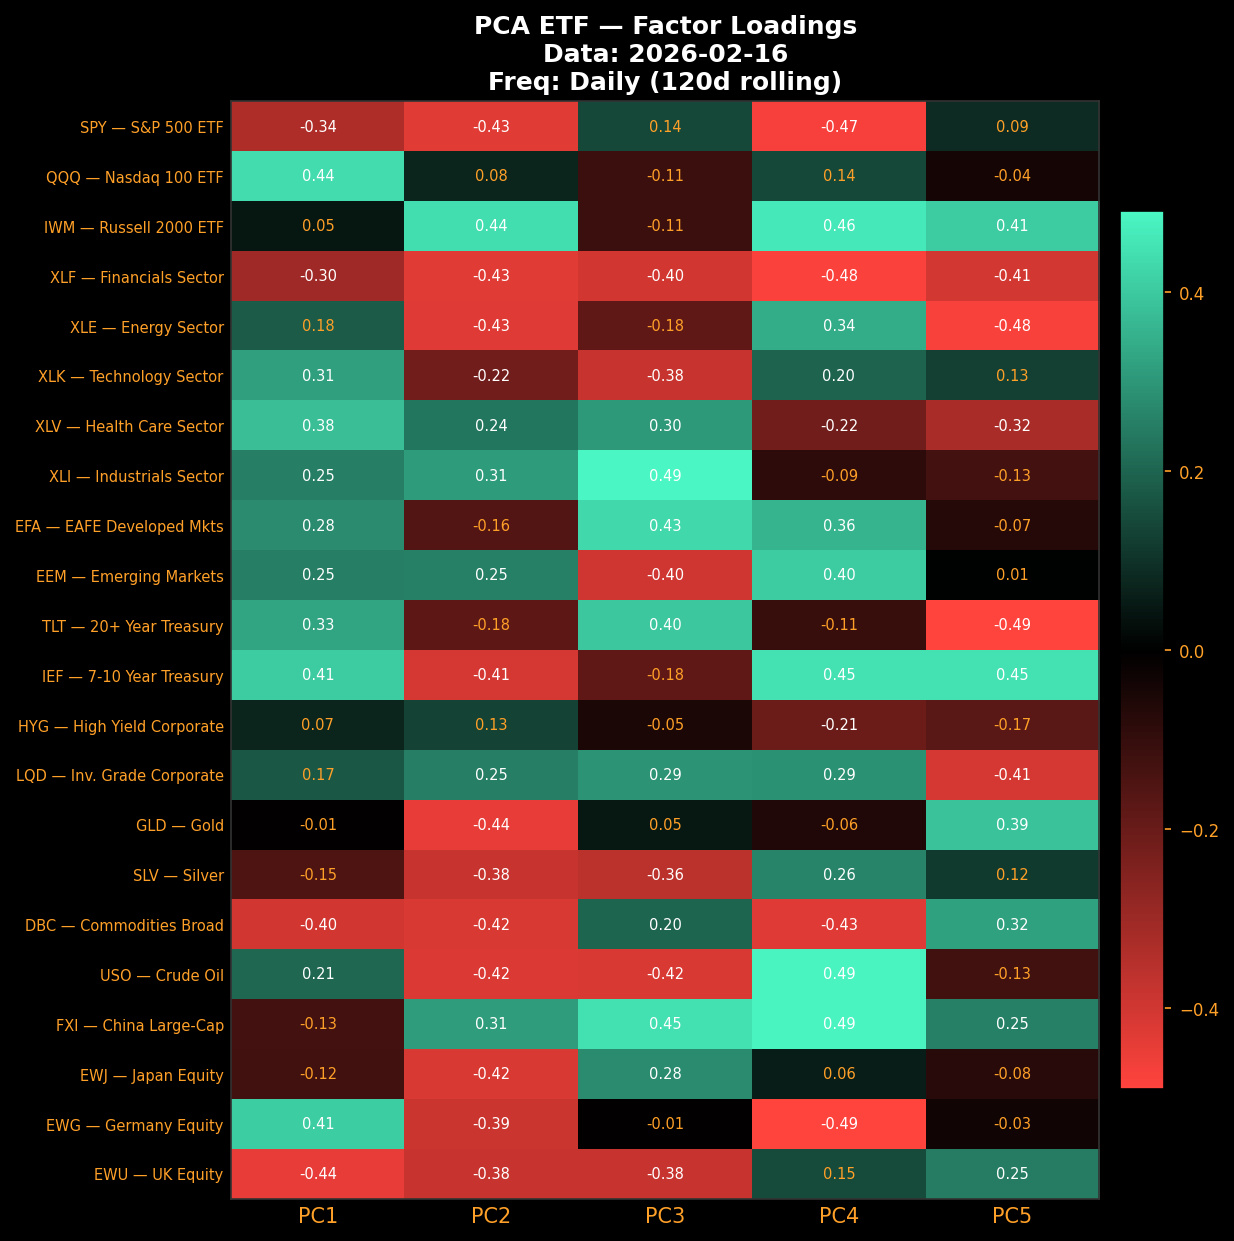

In [49]:
bufs = chart_pca_etf(pca_etf_report, data_date=DATA_DATE)
for i, b in enumerate(bufs):
    print(f"--- Chart {i+1} ---")
    display(Image(data=b.getvalue()))

---
## 6. PCA FX (Loadings + Scores)

In [50]:
display(Markdown(methodology_md("pca_fx")))

### PCA — FX Factor Analysis

Runs PCA on 120-day G10 FX returns to extract the Dollar Factor, Carry Factor, and Regional/Momentum factors. Identifies extreme factor positioning via z-scores.

#### Metrics
**PC1 (Dollar Factor):**
When >60% of FX loadings share the same sign, PC1 captures broad USD strength/weakness. Labeled 'Market Factor' otherwise.

**PC2 (Carry Factor):**
Separates high-yield (AUD, NZD) from low-yield (JPY, CHF) currencies.

**PC3 (Regional/Momentum):**
Captures residual regional or momentum effects.

**PC Scores & Z-Scores:**
Today's projection onto each factor, plus 60-day rolling z-score for extremes.

#### Signals
**Extreme z-scores (|z| > 2):**
Factor is stretched — mean-reversion likely.

**PC1 z > +2:** USD extremely strong, watch for reversal.
**PC1 z < -2:** USD extremely weak.
**PC2 z > +2:** Carry trade extremely stretched.

**Regime Detection:**
Same as ETF PCA — Dimensionality Collapse if PC1 > 60% or eff. dim < 3.0.

--- Chart 1 ---


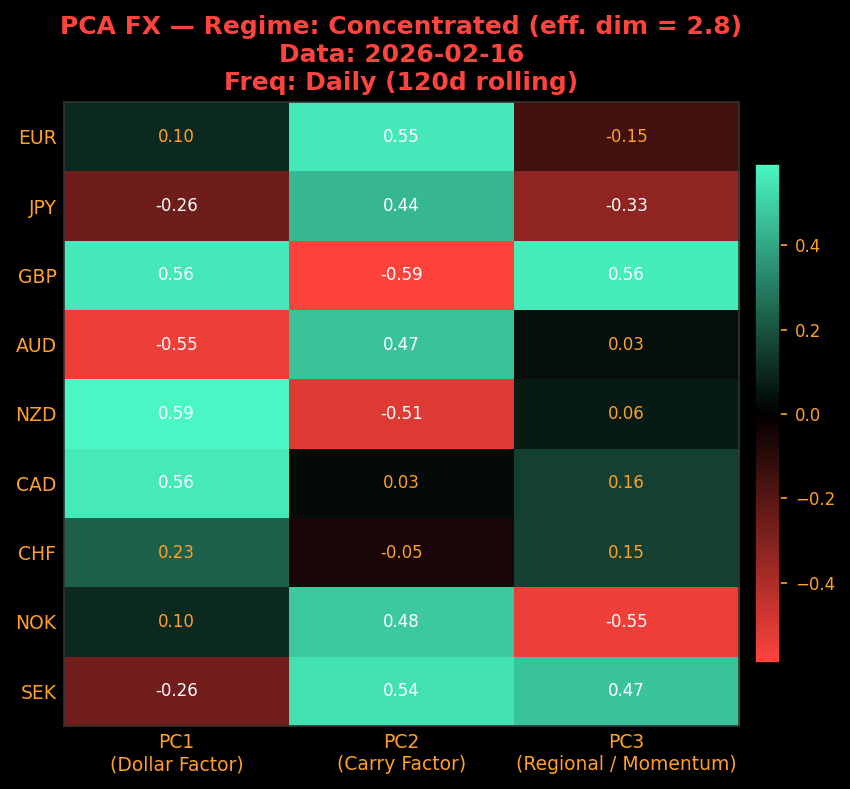

--- Chart 2 ---


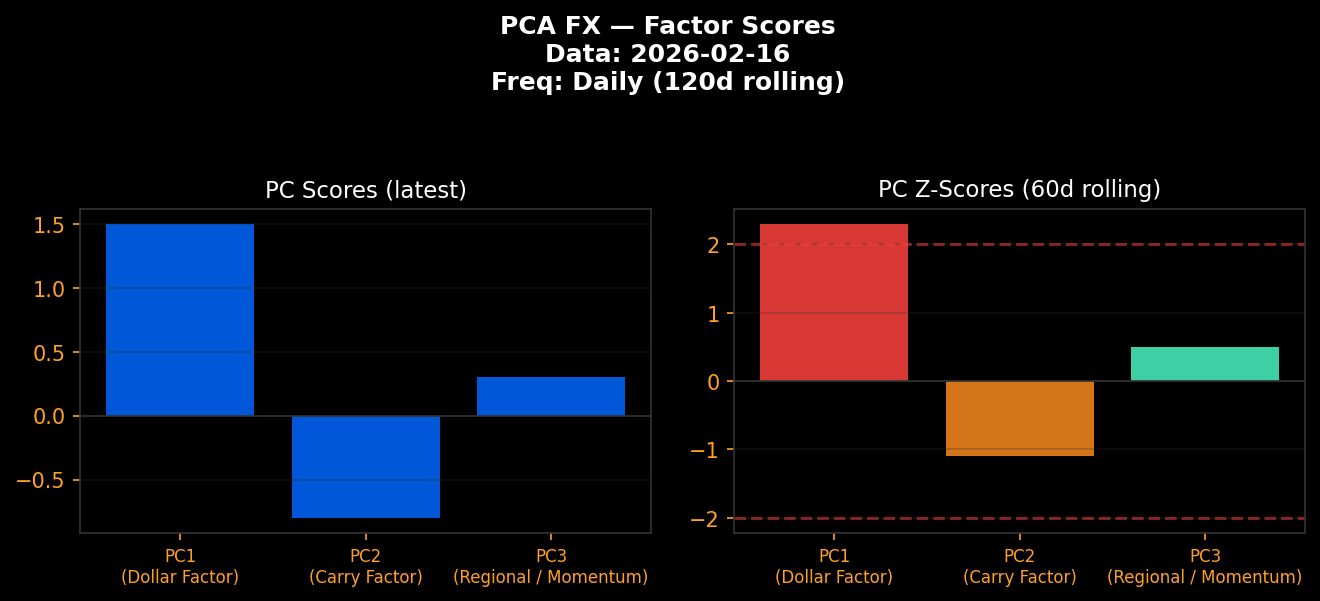

In [51]:
bufs = chart_pca_fx(pca_fx_report, data_date=DATA_DATE)
for i, b in enumerate(bufs):
    print(f"--- Chart {i+1} ---")
    display(Image(data=b.getvalue()))